# Jegadeesh-Titman Rolling Portfolios

_The future is just more of the past waiting to happen_ - Fred D’Aguiar.

The Jegadeesh-Titman rolling portfolios approach explores the phenomenon of price momentum in financial markets, focusing on strategies that involve buying stocks with recent strong performance and selling stocks with weak performance.  Univariate spread portfolios are constructed, which help isolate the return differences between high- and low-ranked stocks.  The following analysis covers key aspects such as overlapping and non-overlapping portfolio returns, the impact of autocorrelation on variance estimation, and statistical hypothesis testing. Additionally, it discusses the Newey-West correction for standard errors and evaluates the power of hypothesis tests.



In [2]:
import math
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import scipy
from scipy.stats import kurtosis, skew, norm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from tqdm import tqdm
from finds.database import SQL, RedisDB
from finds.structured import BusDay, CRSP, CRSPBuffer
from finds.recipes import fractile_split
from finds.utils import plot_date
from secret import credentials, CRSP_DATE

In [3]:
VERBOSE = 0
#%matplotlib qt

In [4]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)

In [5]:
# date range and parameters to construct momentum portfolios
begrebal = 19260630                   # first price date is 19251231
endrebal = bd.endmo(CRSP_DATE, -1)    # last rebal is one month before last CRSP
rebaldates = bd.date_range(begrebal, endrebal, 'endmo')
percentiles = [20, 80]   # quintile spread percentile breakpoints
maxhold = 6    # hold each monthly-rebalanced portfolio for 6 months

In [6]:
# preload monthly dataset into memory
monthly = CRSPBuffer(stocks=crsp, dataset='monthly',
                     fields=['ret', 'retx', 'prc'],
                     beg=bd.begmo(rebaldates[0], -6),
                     end=bd.endmo(rebaldates[-1], 1))

## Price momentum

### Overlapping portfolio returns

First, we estimate the six-month returns of a momentum strategy by averaging monthly observations.

At the end of each month $t$, we calculate the sorting variable as the past six-month return of all stocks in the investment universe. The 20th and 80th percentiles of NYSE-listed stocks serve as thresholds: we go long on stocks in the top fractile and short those in the bottom fractile. Each fractile is weighted by market capitalization, while the spread portfolio return is the equal-weighted difference between the two sub-portfolios. The spread portfolio’s returns over the next six months are recorded on a monthly basis by dividing by six.

A stock is eligible for inclusion if it meets the usual investment universe criteria at the end of the rebalance month and has a non-missing month-end price from six months prior.

In [7]:
stocks = monthly
mom = []
for rebaldate in tqdm(rebaldates):
    # determine pricing dates relative to rebaldate
    beg = bd.endmo(rebaldate, -6)   # require price at beg date
    end = bd.endmo(rebaldate, 0)    # require price at end date
    start = bd.offset(beg, 1)       # starting day of momemtum signal

    # retrieve universe, prices, and momentum signal
    p = [crsp.get_universe(rebaldate),
         stocks.get_ret(beg=start, end=end).rename('mom'),
         stocks.get_section(fields=['prc'], date=beg)['prc'].rename('beg')]
    df = pd.concat(p, axis=1, join='inner').dropna()

    # quintile breakpoints are determined from NYSE subset
    tritile = fractile_split(values=df['mom'],
                             pct=percentiles,
                             keys=df.loc[df['nyse'], 'mom'])

    # construct cap-wtd tritile spread portfolios
    porthi, portlo = [df.loc[tritile==t, 'cap'] for t in [1, 3]]
    port =  pd.concat((porthi/porthi.sum(), -portlo/portlo.sum()))

    # compute and store cap-weighted average returns over (up to) maxhold periods
    begret = bd.offset(rebaldate, 1)
    nhold = min(maxhold, len(rebaldates) - rebaldates.index(rebaldate))
    endret = bd.endmo(begret, nhold - 1)   # if maxhold is beyond end date
    rets = monthly.get_ret(begret, endret)
    ret = rets.reindex(port.index).fillna(0.).mul(port, axis=0).sum()
    mom.append(float(ret) / nhold)

  0%|          | 0/1182 [00:00<?, ?it/s]

100%|██████████| 1182/1182 [11:41:22<00:00, 35.60s/it]  


In [8]:
DataFrame({'mean': np.mean(mom), 'std': np.std(mom)}, index=['Overlapping Returns'])

,mean,std
Overlapping Returns,0.004526,0.024599


### Non-overlapping portfolio returns

A spread portfolio is constructed at the end of each month in the same manner. However, instead of overlapping returns, the return recorded is the equal-weighted average of the following month's returns from six distinct portfolios formed between $ t $ and $ t-5 $. Each month, the weights of stocks in the spread portfolios adjust according to their price changes, following a "buy-and-hold" approach over six months.


In [9]:
ports = []  # to roll 6 past portfolios
jt = []
stocks = monthly
for rebaldate in tqdm(rebaldates):
    
    # determine returns dates relative to rebaldate
    beg = bd.endmo(rebaldate, -6)   # require price at beg date
    end = bd.endmo(rebaldate, 0)    # require price at end date
    start = bd.offset(beg, 1)       # starting day of momemtum signal
    
    # retrieve universe, prices, and momentum signal
    p = [crsp.get_universe(rebaldate),
         stocks.get_ret(beg=start, end=end).rename('mom'),
         stocks.get_section(fields=['prc'], date=beg)['prc'].rename('beg')]
    df = pd.concat(p, axis=1, join='inner').dropna()
    
    # quintile breakpoints determined from NYSE subset
    tritile = fractile_split(values=df['mom'],
                             pct=percentiles,
                             keys=df.loc[df['nyse'], 'mom'])

    # construct cap-wtd tritile spread portfolios
    porthi, portlo = [df.loc[tritile==t, 'cap'] for t in [1, 3]]
    port =  pd.concat((porthi/porthi.sum(), -portlo/portlo.sum()))

    # retain up to 6 prior months of monthly-rebalanced portfolios
    ports.insert(0, port)
    if len(ports) > maxhold:
        ports.pop(-1)

    # compute all 6 portfolios' monthly capwtd returns, and store eqlwtd average
    begret = bd.offset(rebaldate, 1)
    endret = bd.endmo(begret)
    rets = stocks.get_ret(begret, endret)
    ret = np.mean([rets.reindex(p.index).fillna(0.).mul(p, axis=0).sum()
                   for p in ports])
    jt.append(ret)

    # adjust stock weights by monthly capital appreciation
    retx = stocks.get_ret(begret, endret, field='retx')
    ports = [(1 + retx.reindex(p.index).fillna(0.)).mul(p, axis=0)
             for p in ports]

DataFrame({'mean': np.mean(jt), 'std': np.std(jt)}, index=['Non-overlapping Returns'])

  0%|          | 0/1182 [00:00<?, ?it/s]

100%|██████████| 1182/1182 [03:30<00:00,  5.62it/s]


,mean,std
Non-overlapping Returns,0.004502,0.051419


__Correlation with lagged returns__

For the overlapping portfolios, each month's recorded return is (one-sixth of) a six-month return. 
Let $r_t$​ be the return at time $t$. The 6-month return at time $t$, denoted as $R_t$​, is the sum of the past 6 monthly returns: 
$$R_t = r_t+r_{t−1}+r_{t−2}+r_{t−3}+r_{t−4}+r_{t−5}$$

Since we sample monthly, consecutive returns $R_t$​ and $R_{t+1}$​ overlap significantly. Up to 5/6 of adjacent months' returns actually reflect the same month's stock returns. Even returns recorded five months apart share one month of stock returns in common. Ignoring this overlap when estimating variance leads to underestimation of the true variance.

The Jegadeesh-Titman non-overlapping portfolio approach eliminates this issue.



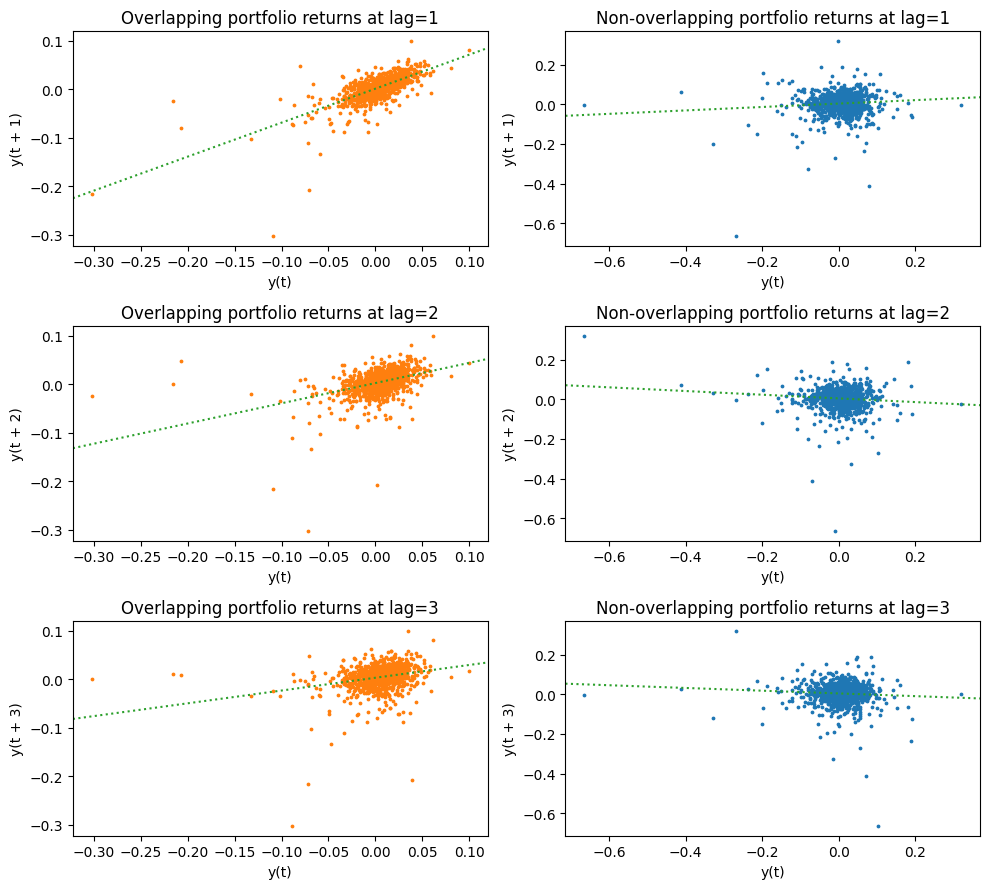

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9))
for lag, ax in zip(range(1, axes.shape[0]+1, 1), axes):
    pd.plotting.lag_plot(Series(mom), lag=lag, ax=ax[0], s=3, c="C1")
    ax[0].set_title(f"Overlapping portfolio returns at lag={lag}")
    r = scipy.stats.linregress(mom[lag:], mom[:-lag])
    ax[0].axline((0, r.intercept), slope=r.slope, ls=':', color="C2")

    pd.plotting.lag_plot(Series(jt), lag=lag, ax=ax[1], s=3, c="C0")
    ax[1].set_title(f"Non-overlapping portfolio returns at lag={lag}")
    r = scipy.stats.linregress(jt[lag:], jt[:-lag])
    ax[1].axline((0, r.intercept), slope=r.slope, ls=':', color="C2")
plt.tight_layout()

__Plot cumulative monthly average returns__

Jegadeesh-Titman non-overlapping 6-month momentum portfolio cumulative returns

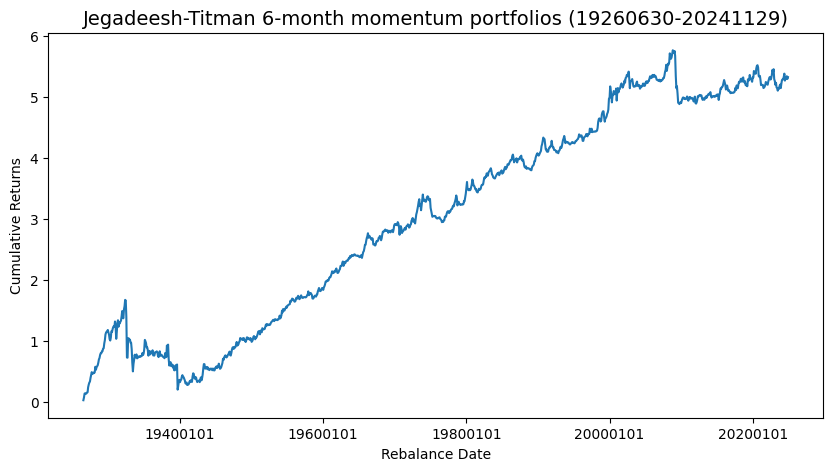

In [20]:
fig, ax = plt.subplots(figsize=(10, 5), clear=True)
plot_date(DataFrame(index=rebaldates, data=np.cumsum(jt), columns=['momentum']),
          ax=ax, fontsize=10, rotation=0,
          ylabel1='Cumulative Returns', xlabel='Rebalance Date',
          title=f'Jegadeesh-Titman 6-month momentum portfolios ({rebaldates[0]}-{rebaldates[-1]})')
plt.show()

__Plot histogram of monthly returns__

Distribution of Jegadeesh-Titman non-overlapping 6-month momentum portfolio returns

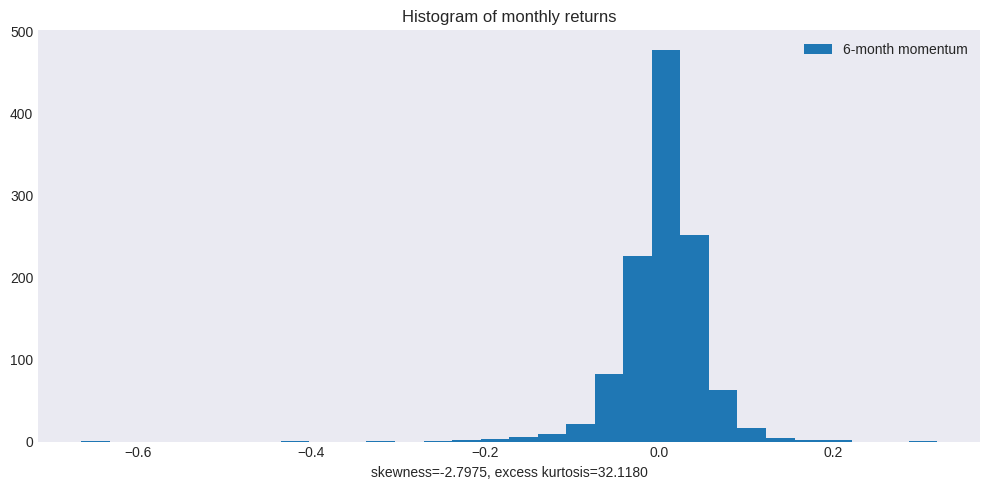

In [ ]:
fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 5))
ax.hist(jt, bins=30)
ax.set_title(f"Histogram of monthly returns")
ax.legend(['6-month momentum'])
kurt = kurtosis(jt, bias=True, fisher=True)  # excess kurtosis
skewness = skew(jt, bias=True)
ax.set_xlabel(f"skewness={skewness:.4f}, excess kurtosis={kurt:.4f}")
plt.tight_layout()

## Hypothesis testing

A hypothesis test makes a precise statement about population parameters and evaluates the likelihood of observing the data under a given assumption.

- The _null hypothesis_ specifies the true value of a parameter to be tested, often $H_0: \hat{\mu} = \mu_0$
- The _test statistic_ is a summary of the observed data that has a known distribution when the null hypothesis is true, e.g. $T - \dfrac{\hat{\mu} - \mu_0}{\sqrt{\sigma^2/n}} \sim N(0,1)$
- The _alternative hypothesis_ defines the range of values of the parameter where the null should be rejected, e.g. $H_a: \hat{\mu} \ne \mu_0$
  - In some testing problems, the alternative hypothesis is not the full complement of the null, for example, a _one-sided alternative_ $H_a: \hat{\mu}> \mu_0$, which is used whtn the outcome of interest is only above or below the value assumed by the null.
- The _critical value_ $C_{\alpha}$ marks the start of a range of values where the test statistic is unlikely to fall in, if the null hypthesis were true, e.g. $C_{\alpha} = \Phi^{-1}(1 - \alpha/2) = 1.96$ when $\alpha=5\%$ for a two-sided test. This range is known as the _rejection region_.
- The _size_ of the test is the probability of making a _Type I error_ of rejecting null hypothesis that is actually true. A test is said to have _significance level_ $\alpha$ if its _size_ is less than or equal to $\alpha$. This reflects the aversion to rejecting a null hypothesis that is, in fact, true.
- The _p-value_ is the probability of obtaining a test statistic at least as extreme as the one we observed from the sample, if the null hypothesis were true, e.g. $p = 2(1 - \Phi(|T|))$ for a two-sided test.



### Confidence Interval

A $1 - \alpha$ _confidence interval_ contains the values surrounding the test statistic that cannot be rejected when using a test size of $\alpha$, e.g. $[\hat{\mu} - C_{\alpha}\dfrac{\sigma^2}{\sqrt{n}}, \hat{\mu} + C_{\alpha}\dfrac{\sigma^2}{\sqrt{n}}]$ for a two-sided interval

### Newey-West corrected t-stats

Standard errors are underestimated when assuming independent observations, as this assumption does not hold for overlapping returns. The **Newey-West (1987) estimator** corrects for heteroskedasticity and autocorrelation by specifying a "maximum lag" for autocorrelation control. A common choice is $ L = $ the fourth root of the number of observations (e.g., Greene, *Econometric Analysis*, 7th ed., p. 960).

Applying the Newey-West correction nearly doubles the estimated standard error for overlapping portfolios, but it has a minimal effect on non-overlapping returns.

In [11]:
print('n =', len(mom), '   L =', math.ceil(len(mom)**(1/4)))
results = []
for rets, label in zip([mom, jt], ['Overlapping', 'Non-overlapping']):
    data = DataFrame(rets, columns=['ret'])

    # raw t-stats
    reg = smf.ols('ret ~ 1', data=data).fit()
    uncorrected = Series({stat: round(float(getattr(reg, stat).iloc[0]), 6)
                          for stat in ['params','bse','tvalues','pvalues']},
                         name='uncorrected')  # coef, stderr, t-value, P>|z|

    # Newey-West correct t-stats
    reg = smf.ols('ret ~ 1', data=data)\
             .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    corrected = Series({stat: round(float(getattr(reg, stat).iloc[0]), 6)
                        for stat in ['params','bse','tvalues','pvalues']},
                       name='NeweyWest')   # coef, stderr, t-value, P>|z|

    # merge into intermediate dataframe with multicolumn index
    df = pd.concat([uncorrected, corrected], axis=1)
    df.columns = pd.MultiIndex.from_product([[label], df.columns])
    results.append(df)

pd.concat(results, axis=1).rename_axis('Standard Errors')


n = 1182    L = 6


Overlapping           Non-overlapping          
                uncorrected NeweyWest     uncorrected NeweyWest
Standard Errors                                                
params             0.004526  0.004526        0.004502  0.004502
bse                0.000716  0.001285        0.001496  0.001463
tvalues            6.322644  3.522659        3.009069  3.078432
pvalues            0.000000  0.000427        0.002676  0.002081

### Power of Test

A **Type II error** occurs when the alternative hypothesis is true but the null is not rejected. The probability of a Type II error is denoted by $ \beta $, while **power** ($ 1 - \beta $) represents the probability of correctly rejecting a false null hypothesis.

Unlike test size, the power of a test depends on:
1. Sample size
2. Test size ($ \alpha $)
3. The distance between the true parameter value and the null hypothesis value

For a one-sided test $ H_a: \hat{\mu} > \mu_0 $, power is given by:

$$
1 - \beta(\alpha) = \Phi \left( C_{\alpha} \frac{\sigma^2}{\sqrt{n}} \middle| \mu_a, \frac{\sigma^2}{\sqrt{n}} \right)
$$

In [12]:
DataFrame(data={"True Null": ['correct', '(1 - alpha)', 'Type I Error', 'Size: (alpha)'], 
                "False Null": ['Type II Error', '(beta)', 'correct', 'Power: (1-beta)']},
          index=['Accept Null', '', 'Reject Null', ''])\
          .rename_axis(index='Decision')

,True Null,False Null
Decision,,
Accept Null,correct,Type II Error
,(1 - alpha),(beta)
Reject Null,Type I Error,correct
,Size: (alpha),Power: (1-beta)


__Effect of Test Size (alpha) and True Alternative (mu) on Power__


In [13]:
# Assumtions
alternative = 0.06   # alternative hypothesis that annualized mean is as large as 6%
scale = np.std(jt) / np.sqrt(len(jt))  # assumed scale (std dev or volatility)

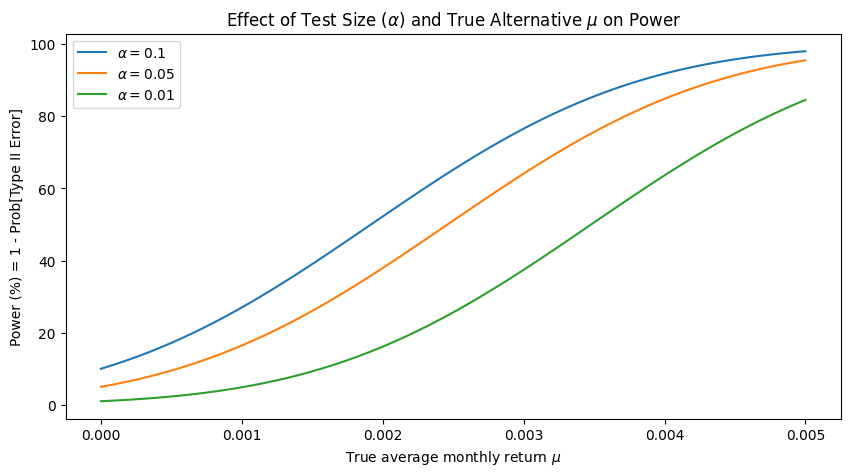

In [14]:
# Vary test size (alpha) and true mean (mu)
mu = np.linspace(0, alternative/12, 100)   # vary true mean
plt.figure(figsize=(10, 5))
for alpha in [0.1, 0.05, 0.01]:            # vary test size
    power = 1 - norm.cdf(norm.ppf(1 - alpha) * scale, loc=mu, scale=scale)
    plt.plot(mu, 100*power, label=f"$\\alpha=${alpha}")
plt.title("Effect of Test Size ($\\alpha$) and True Alternative $\\mu$ on Power")
plt.ylabel('Power (%) = 1 - Prob[Type II Error]')
plt.xlabel('True average monthly return $\\mu$')
plt.legend()

__Effect of Sample Size on Power__

In [15]:
# Assumptions
volatility = np.std(jt)
alternative = 0.06/12     # mean of the alternate hypotehsis
alpha = 0.05              # desired size of the test

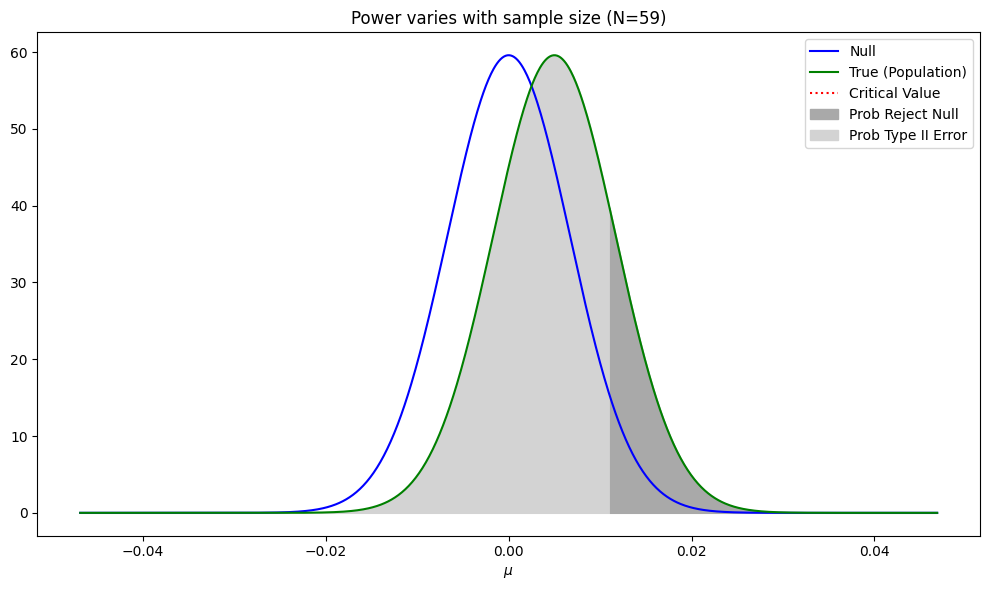

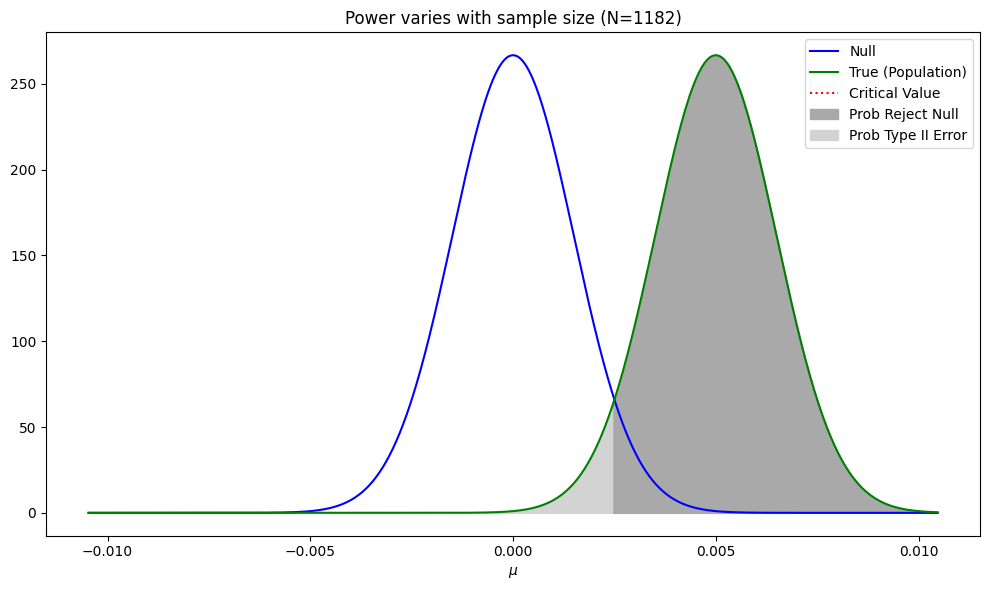

In [16]:
# Compare large and small sample sizes
for N in [len(jt) // 20, len(jt)]:

    # define null and alternate distributions given sample size 
    scale = volatility/np.sqrt(N)   # scaled by square root of sample size
    null_dist = norm(0, scale)
    alt_dist = norm(alternative, scale)
    critical_val = null_dist.ppf(1-alpha)  # critical value to reject null

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.linspace(-7 * scale, 7 * scale, 1000)
    ax.plot(x, null_dist.pdf(x), color='blue')  # plot null distribution
    ax.plot(x, alt_dist.pdf(x), color='green')  # plot alt distribution
    ylim = plt.ylim()[0]
    ax.axvline(x=critical_val, ymax=ylim, ls=':', color='r') # critical value
    px = x[x > critical_val]
    ax.fill_between(px, alt_dist.pdf(px), color='darkgrey')  # rejection region
    px = x[x < critical_val]
    ax.fill_between(px, alt_dist.pdf(px), color='lightgrey') # acceptance region
    ax.set_title(f"Power varies with sample size (N={N})")
    ax.set_xlabel("$\mu$")
    plt.legend(['Null', 'True (Population)', 'Critical Value',
                'Prob Reject Null', 'Prob Type II Error'])
    plt.tight_layout()


**References:**

Jegadeesh, Narasimhan, and Sheridan Titman (1993), "Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency". Journal of Finance. March 1993, Volume 48, Issue 1, Pages 65-91.

Newey, Whitney K, West, Kenneth D (1987). "A Simple, Positive Semi-definite, Heteroskedasticity and Autocorrelation Consistent Covariance Matrix". Econometrica. 55 (3): 703–708.

Hong, Harrison, Terence Lim, Jeremy C. Stein, 2000, "Bad News Travels Slowly: Size, Analyst Coverage, and the Profitability of Momentum Strategies", Volume 55, Issue 1, Pages 265-295. https://doi.org/10.1111/0022-1082.00206

FRM Exam Book Part I Quantative Analysis Chapter 6

*MIT License. Copyright 2021-2025, Terence Lim*